<a href="https://colab.research.google.com/github/ikanx101/G-Colab/blob/main/Satria_Data_ITB_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
# install.packages("caret")
# install.packages("keras")

In [167]:
# dimulai dari hati yang bersih
rm(list=ls())

# memanggil semua libraries yang diperlukan
library(dplyr)
library(tidyr)
library(caret)
library(keras)
library(tensorflow)

# kita akan ambil datanya
df_train = read.csv("train.csv")
df_test  = read.csv("test.csv")

# kita gabung dulu
df       = bind_rows(df_train,df_test)

# kita simpan target
target   = df$target
df       = df |> select(-target,-id)

# kita lihat terlebih dahulu struktur datanya seperti apa
str(df)

'data.frame':	760 obs. of  35 variables:
 $ hs         : int  23 21 17 26 20 14 15 20 14 6 ...
 $ hst        : int  6 5 6 11 6 5 4 6 4 4 ...
 $ hf         : int  7 5 8 12 11 16 14 17 15 5 ...
 $ hc         : int  10 8 7 6 3 5 4 8 7 3 ...
 $ hy         : int  2 1 1 1 3 1 3 6 1 1 ...
 $ hr         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ b365h      : num  1.95 1.28 1.28 1.9 2.5 1.22 1.22 1.89 2.2 4.2 ...
 $ b365d      : num  3.5 6.5 6.5 3.79 3.2 7 7 3.79 3.2 3.79 ...
 $ bwh        : num  1.91 1.26 1.28 1.83 2.5 1.2 1.25 1.85 2.15 4.25 ...
 $ bwd        : num  3.5 6 5.75 3.75 3.1 7 6.5 3.6 3.1 3.8 ...
 $ iwh        : num  1.9 1.27 1.33 1.9 2.5 1.25 1.25 1.95 2.1 4.3 ...
 $ iwd        : num  3.5 5.8 5.5 3.5 3.1 6 6.1 3.45 3.3 3.5 ...
 $ psh        : num  1.93 1.3 1.27 1.91 2.52 1.23 1.22 1.88 2.19 4.75 ...
 $ psd        : num  3.59 6.14 6.08 3.72 3.17 7.25 6.92 3.85 3.15 3.93 ...
 $ whh        : num  1.85 1.29 1.25 1.91 2.5 1.2 1.2 1.85 2.2 4.33 ...
 $ whd        : num  3.5 6 6 3.75 3.1 7 6 3.6 3

In [168]:
preProcess_range_model = preProcess(df, method = c("range"))
df                     = predict(preProcess_range_model, newdata = df) #variabel targetnya hilang di sini
df$status              = target

In [169]:
train = df |> filter(!is.na(status))
test  = df |> filter(is.na(status))

nrow(train)
table(train$status)

nrow(test)
table(test$status)

[1] 600


  0   1 
300 300 

[1] 160

< table of extent 0 >

In [170]:
# kita ubah targetnya ke bentuk matriks
train_label_raw   = train$status
train_label_clean = to_categorical(train_label_raw)
train_matrix      = as.matrix(train[-ncol(train)])

Model: "sequential_18"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_99 (Dense)                   (None, 30)                      1080        
 dense_98 (Dense)                   (None, 40)                      1240        
 dense_97 (Dense)                   (None, 30)                      1230        
 dense_96 (Dense)                   (None, 20)                      620         
 dense_95 (Dense)                   (None, 10)                      210         
 dense_94 (Dense)                   (None, 5)                       55          
 dense_93 (Dense)                   (None, 2)                       12          
Total params: 4,447
Trainable params: 4,447
Non-trainable params: 0
________________________________________________________________________________


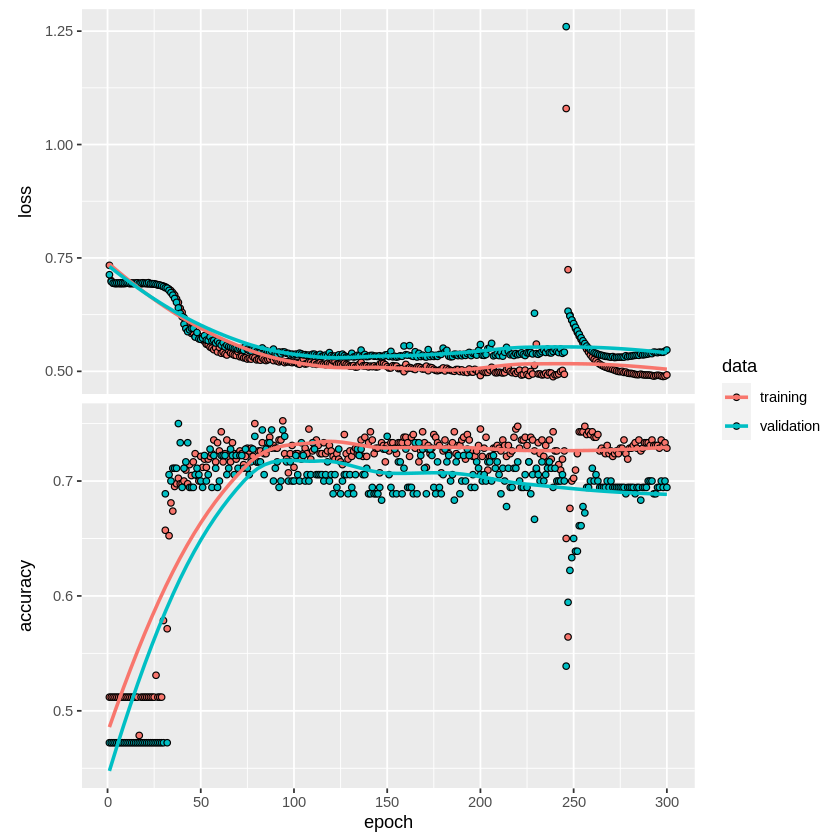

In [171]:
model = keras_model_sequential()
model %>%
  layer_dense(units       = 30,activation = 'sigmoid',
              input_shape = c(ncol(train_matrix))) %>%
  layer_dense(units       = 40, activation = 'softmax') %>%
  layer_dense(units       = 30, activation = 'softmax') %>%
  layer_dense(units       = 20, activation = 'sigmoid') %>%
  layer_dense(units       = 10, activation = 'sigmoid') %>%
  layer_dense(units       = 5, activation = 'softmax') %>%
  layer_dense(units       = 2, activation = 'relu')

summary(model)

model %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=c('accuracy')
)

fitModel =
  model %>%
  fit(train_matrix,
      train_label_clean,
      epochs           = 300,
      batch_size       = 10,
      validation_split = 0.3)

plot(fitModel)

In [172]:
# evaluasi dengan train
model %>% evaluate(train_matrix, train_label_clean, verbose = 0)

loss  accuracy 
0.5062641 0.7250000

In [173]:
test_matrix       = as.matrix(test[-ncol(train)])
pred_test = predict(model, test_matrix) %>% k_argmax() %>% as.vector()

submisi = data.frame(id     = 1:160,
                     target = pred_test)

write.csv(submisi,"submitted.csv",row.names = F)